## Configuration variables

Index | Recommended configuration
:---: | :---:
1 | Rotation up to 20º<br>shear up to 15º<br>Horizontal and vertical flip<br>Vertical and horizontal shift up to 20%<br>Zoom out up to 20%
2 | Rotation up to 15º<br>Vertical and horizontal flip<br>Image resize up to 10%

In [1]:
### Environment
csvMetadataPath = "/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/HAM10000_metadata.csv" # "HAM10000_metadata.csv"
imagesPath = "gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/" # "images"
drive = True

### Height and weight of images to be crop
h, w = 224, 224

### Remove duplicates
removeDuplicates = False
removeNv = True
"""
0 0 10015
0 1 3310
1 0 5514
1 1 1099
"""

### Segmentation
segmentation = False
segmentationNum = 100
compactnessNum = 10

### Data augmentation
dataAugmentation = False
rotation = .18
widthShift, heightShift = .12, .12
channelShift = .15
shear = .12
zoom = .2
hFlip, vFlip = True, True
fill = 'nearest' # constant, nearest, reflect, wrap
cval = .5 # case the previous is constant
bright = [.6,1.4]

### Normalization
featureCenter = False
sampleCenter = False
featureStdNorm = False
sampleStdNorm = False
zcaWhitening = False
standardScalerNorm = False
minMaxScalerNorm = False

### Model configuration
epochs = 5
batchSize = 830
if removeNv:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc':   1, # 1.0 - 'Carcinoma basocelular'
        'bkl':   2, # 2.0 - 'Keratose benigna'
        'df':    3, # 3.0 - 'Dermatofibroma'
        'vasc':  4, # 4.0 - 'Lesao vascular'
        'mel':   5, # 5.0 - 'Melanoma'
    }
    totalImages = 1099 if removeDuplicates else 3310
else:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc':   1, # 1.0 - 'Carcinoma basocelular'
        'bkl':   2, # 2.0 - 'Keratose benigna'
        'df':    3, # 3.0 - 'Dermatofibroma'
        'vasc':  4, # 4.0 - 'Lesao vascular'
        'mel':   5, # 5.0 - 'Melanoma'
        'nv':    6  # 6.0 - 'Nevo melanocitico'
    }
    totalImages = 5514 if removeDuplicates else 10015
totalClasses = len(cancerType)
useCustomOptimizer = False

# Library imports and directory mount

In [2]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
import cv2, glob, os, random, warnings

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from skimage.segmentation import slic
from skimage.transform import resize

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore') 

sns.set() # for ploting

if drive:
    from google.colab import drive
    drive.mount('/content/gdrive')
    !ls
    !ls 'gdrive/MyDrive'

Mounted at /content/gdrive
drive  gdrive  sample_data
'arq win'				        Invest.gsheet
'Ativação windows 10'			        Livros
'Colab Notebooks'			       'Mão de obra.gdoc'
 Currículo				        profile
 Documentos				        Programação
 Estudu					        PUC
 git_auth.txt				        Random
'Henrique Sartori Siqueira - Glicemia.gsheet'  'Recuperação de contas'
 iLovePDF				       'Untitled Diagram.drawio'


# Dataset import (CSV Metadata)

In [3]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization'])
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace=True)                         # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['duplicate'].apply(lambda x: 0 if x in uniqueLesions else 1) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()

0    5514
1    4501
Name: duplicate, dtype: int64

Removing Duplicates

In [5]:
if removeDuplicates:
    datasetMetadata = datasetMetadata[datasetMetadata['duplicate'] == 0]
if removeNv:
    datasetMetadata = datasetMetadata[datasetMetadata['cancerId'] != 'nv']
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,bkl,1
1,HAM_0000118,ISIC_0025030,bkl,1
2,HAM_0002730,ISIC_0026769,bkl,1
3,HAM_0002730,ISIC_0025661,bkl,1
4,HAM_0001466,ISIC_0031633,bkl,1


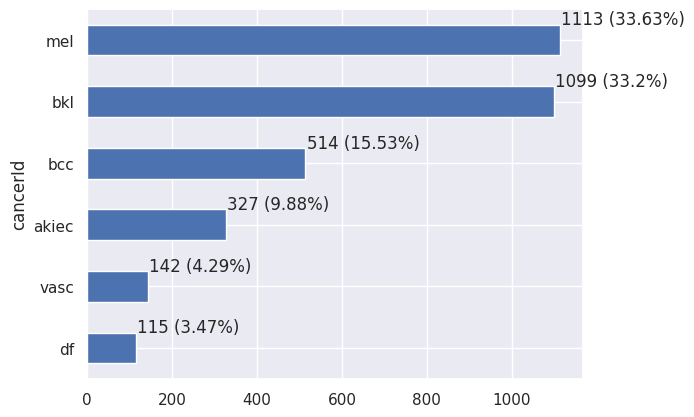

cancerId
df        115
vasc      142
akiec     327
bcc       514
bkl      1099
mel      1113
dtype: int64
Total:  3310


In [6]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()
total = datasetMetadata.shape[0]

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/total*100, 2)) + '%)') # Set the percentage of each cancer class

plt.show()

print(labelSize)
print("Total: ",labelSize.sum())

In [7]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType)
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,2,1
1,HAM_0000118,ISIC_0025030,2,1
2,HAM_0002730,ISIC_0026769,2,1
3,HAM_0002730,ISIC_0025661,2,1
4,HAM_0001466,ISIC_0031633,2,1


# Dataset import (Imgs)

https://scikit-image.org/docs/stable/api/skimage.segmentation.html

In [8]:
# Path to the dataset images
# /content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/<imgId>.jpg

images = []
loadedImages = 0

for index, row in datasetMetadata.iterrows():
    img = cv2.imread(imagesPath+row['imageId']+'.jpg') # Collect the image from drive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Invert color BGR => RGB
    if segmentation:
        # Segment the image into superpixels using SLIC
        segments = slic(img, n_segments=segmentationNum, compactness=compactnessNum)

        # Resize the superpixels to widthxheight pixels
        resizedSegments = resize(segments, (w, h), order=0, anti_aliasing=False)

        # Reassemble the resized superpixels to form the resized image
        img = resize(img, resizedSegments.shape, order=3, anti_aliasing=True)
    else:
        img = cv2.resize(img, (h, w))            # Resize the image according to params provided
    images.append(img)
    
    loadedImages = loadedImages + 1
    if loadedImages % 1000 == 0:
        print(loadedImages)

1000
2000
3000


3310
lesionId      HAM_0000118
imageId      ISIC_0027419
cancerId                2
duplicate               1
Name: 0, dtype: object
(224, 224, 3)


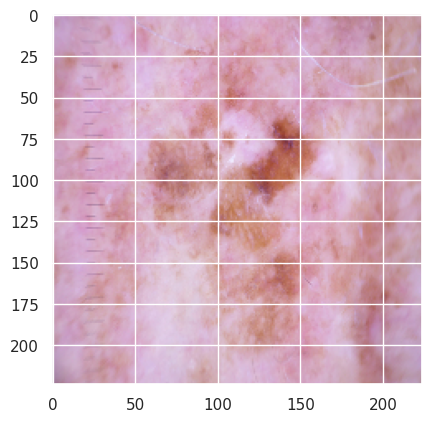

In [9]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

# Images treatment

In [10]:
images = np.array(images) # Transform images list into np array
print(images[0])
print(images.shape)

images = images.reshape(totalImages, h * w * 3) # 4d -> 2d
print(images.shape)

[[[186 150 192]
  [189 153 195]
  [191 155 198]
  ...
  [195 153 167]
  [194 155 168]
  [196 157 169]]

 [[187 150 193]
  [192 154 195]
  [194 156 198]
  ...
  [194 153 167]
  [194 158 168]
  [197 156 170]]

 [[190 150 193]
  [191 152 193]
  [194 153 193]
  ...
  [193 153 163]
  [197 157 171]
  [195 155 166]]

 ...

 [[160 123 156]
  [163 126 158]
  [164 128 158]
  ...
  [185 153 176]
  [182 150 169]
  [178 146 158]]

 [[158 123 155]
  [158 125 155]
  [164 125 155]
  ...
  [185 156 182]
  [181 149 169]
  [176 144 158]]

 [[154 121 151]
  [158 120 152]
  [160 121 150]
  ...
  [183 158 184]
  [181 151 170]
  [175 145 159]]]
(3310, 224, 224, 3)
(3310, 150528)


## Model input treatment

Spliting in training and test balancing the batches by the cancer id

In [11]:
XTrain, XTest, YTrain, YTest = train_test_split(images,datasetMetadata['cancerId'], test_size = 0.2, train_size = 0.8, stratify=datasetMetadata['cancerId'])

Normalization

In [12]:
del images
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(YTrain.head())

(662, 150528)
(2648, 150528)
166     2
9723    0
1503    5
9988    0
561     2
Name: cancerId, dtype: int64


Resize

In [13]:
print(XTrain.shape[0])
print(XTest.shape[0])
XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YTest = np_utils.to_categorical(YTest)

print(XTrain[0].shape)
print(XTrain[0])

2648
662
(224, 224, 3)
[[[188. 158. 162.]
  [188. 161. 160.]
  [189. 161. 166.]
  ...
  [163. 143. 139.]
  [165. 141. 140.]
  [166. 138. 136.]]

 [[189. 157. 159.]
  [189. 159. 161.]
  [190. 161. 162.]
  ...
  [167. 142. 138.]
  [166. 140. 135.]
  [163. 139. 134.]]

 [[188. 159. 158.]
  [189. 159. 159.]
  [190. 161. 161.]
  ...
  [166. 140. 139.]
  [164. 140. 134.]
  [166. 137. 129.]]

 ...

 [[186. 160. 164.]
  [186. 160. 162.]
  [186. 162. 163.]
  ...
  [173. 149. 148.]
  [173. 148. 148.]
  [173. 148. 149.]]

 [[187. 159. 161.]
  [186. 162. 164.]
  [189. 158. 162.]
  ...
  [171. 152. 148.]
  [171. 151. 153.]
  [169. 151. 147.]]

 [[189. 158. 163.]
  [185. 159. 163.]
  [185. 158. 161.]
  ...
  [172. 152. 148.]
  [171. 152. 149.]
  [175. 149. 148.]]]


### Data augmentation

Only be applied in the training set

In [14]:
if dataAugmentation:
    datagen = ImageDataGenerator(
            # Normalizations
            featurewise_center = featureCenter,
            samplewise_center = sampleCenter,
            featurewise_std_normalization = featureStdNorm,
            samplewise_std_normalization = sampleStdNorm,
            zca_whitening = zcaWhitening,
            # Image modifications
            rotation_range = rotation,
            zoom_range = zoom,
            channel_shift_range = channelShift,
            fill_mode = fill,
            cval = cval,
            width_shift_range = widthShift,
            height_shift_range = heightShift,
            horizontal_flip = hFlip,
            brightness_range = bright,
            shear_range = shear,
            vertical_flip = vFlip)

    print(XTrain.shape)
    print(XTrain.size)
    datagen.fit(XTrain)
    print(XTrain.shape)
    print(XTrain.size)

# Model training

Loading pre treined model

In [15]:
model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, classes=totalClasses, input_shape=(h,w,3))

for layer in model.layers:
  layer.trainable = False

prediction = tf.keras.layers.Dense(totalClasses, activation='softmax')(tf.keras.layers.Flatten()(model.output))

model = tf.keras.Model(inputs=model.input, outputs=prediction)
model.summary()

350926856/350926856 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 56, 56, 128)  6528       ['convnext_base_prestem_normaliza
 )                         

In [16]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
if useCustomOptimizer:
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
else:
    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
print("XTest = ", XTest.shape)
print("YTest = ", YTest.shape)
print("XTrain = ", XTrain.shape)
print("YTrain = ", YTrain.shape)

XTest =  (662, 224, 224, 3)
YTest =  (662, 6)
XTrain =  (2648, 224, 224, 3)
YTrain =  (2648, 6)


fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

In [18]:
if dataAugmentation:
    history = model.fit_generator(datagen.flow(XTrain, YTrain, batch_size = batchSize),
                                epochs = epochs, validation_data = (XTest,YTest),
                                verbose = 2, steps_per_epoch=XTrain.shape[0] // batchSize,
                                callbacks = [learning_rate_reduction])
else:
    history = model.fit(XTrain, YTrain, validation_data=(XTest, YTest), epochs=epochs, batch_size=batchSize, verbose=2)

Epoch 1/5
4/4 - 7599s - loss: 8.2379 - accuracy: 0.3248 - val_loss: 10.4906 - val_accuracy: 0.3520 - 7599s/epoch - 1900s/step
Epoch 2/5
4/4 - 7604s - loss: 7.1557 - accuracy: 0.4758 - val_loss: 4.7459 - val_accuracy: 0.4683 - 7604s/epoch - 1901s/step
Epoch 3/5
4/4 - 7680s - loss: 4.2384 - accuracy: 0.5128 - val_loss: 3.7460 - val_accuracy: 0.5378 - 7680s/epoch - 1920s/step
Epoch 4/5
4/4 - 7699s - loss: 2.6276 - accuracy: 0.6552 - val_loss: 3.2227 - val_accuracy: 0.6088 - 7699s/epoch - 1925s/step
Epoch 5/5
4/4 - 7705s - loss: 2.0924 - accuracy: 0.6911 - val_loss: 2.5853 - val_accuracy: 0.6465 - 7705s/epoch - 1926s/step


# Statistics

Training epochs statistics

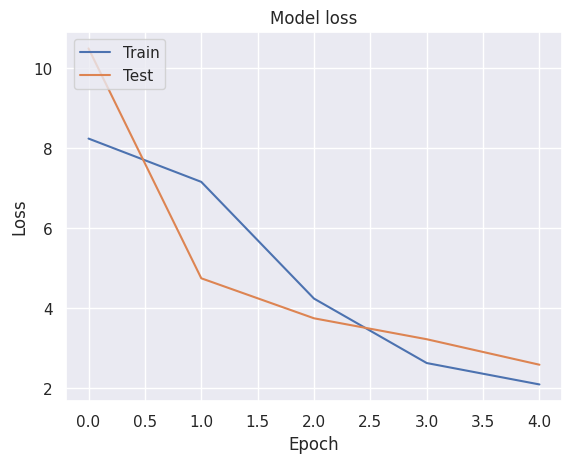

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

General eficiency

In [20]:
model.evaluate(XTest,YTest, verbose=0)

[2.5852673053741455, 0.6465256810188293]

Confusion matrix

21/21 [==============================] - 1800s 85s/step


Text(0.5, 93.24999999999997, 'Predicted label')

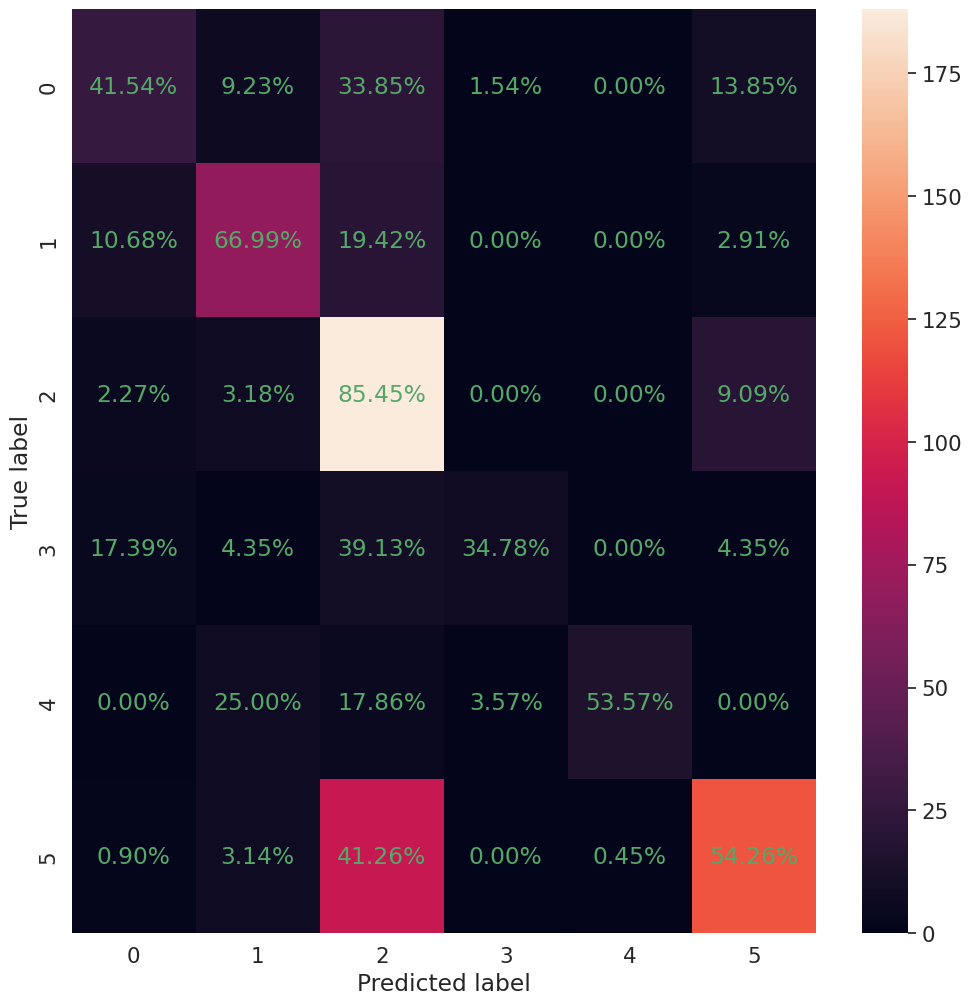

In [21]:
cm=confusion_matrix(YTest.argmax(axis=1),model.predict(XTest).argmax(axis=1))
dfCm = pd.DataFrame(cm, range(totalClasses),range(totalClasses))
plt.figure(figsize = (12,12))
sns.set(font_scale=1.4) # for label size
sns.heatmap(dfCm, annot=False, annot_kws={"size": 12}) # font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, "{:.2f}%".format(cm[i, j] / cm[i].sum() * 100), va="center", ha="center", color="g")


plt.ylabel('True label')
plt.xlabel('Predicted label')

Saving model into google drive

In [22]:
model.save('/content/gdrive/MyDrive/PUC/TCC/Notebooks/convNextNoTreatmentDup.h5')